In [1]:
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV

In [2]:
dataset=pd.read_csv("FINAL_DATASET.csv")
dataset.shape

(1408, 16)

In [3]:
dataset.head()

,Unnamed: 0,website_url,website_name,cleaned_website_text,total_matched,matched_category_keywords,Category1,percent1,Category2,percent2,Category3,percent3,Category4,percent4,Category5,percent5
0,0,https://www.booking.com/index.html?aid=1743217,booking,official site good hotel accommodation big sav...,281,"['hotel', 'saving', 'hotel', 'destination', 'h...",Travel,62.277580,News,16.725979,Business/Corporate,14.590747,Social Networking and Messaging,11.032028,E-Commerce,9.252669
1,1,https://travelsites.com/expedia/,travelsites,expedia hotel book sites like use vacation wor...,306,"['hotel', 'book', 'vacation', 'city', 'offer',...",Travel,42.483660,E-Commerce,16.013072,Computers and Technology,15.359477,Business/Corporate,15.032680,Social Networking and Messaging,10.457516
2,2,https://travelsites.com/tripadvisor/,travelsites,tripadvisor hotel book sites like previously d...,114,"['hotel', 'book', 'deal', 'review', 'offer', '...",Travel,50.000000,Social Networking and Messaging,15.789474,Photography,13.157895,Computers and Technology,12.280702,E-Commerce,9.649123
3,3,https://www.momondo.in/?ispredir=true,momondo,cheap flights search compare flights momondo f...,411,"['cheap', 'search', 'cheap', 'flight', 'fare',...",Travel,67.396594,News,19.708029,Business/Corporate,13.381995,E-Commerce,12.408759,Computers and Technology,7.055961
4,4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,ebookers,bot create free account create free account si...,210,"['booking', 'travel', 'travel', 'flight', 'hot...",Travel,30.000000,Social Networking and Messaging,19.523810,News,18.095238,E-Commerce,11.904762,Business/Corporate,8.095238


The dataset contains features that are not necessary to solve our multi-classification problem. For this text classification problem, we are going to build another dataframe that contains ‘website_url’,'cleaned_website_text' and 'Category'

In [4]:
df = dataset[['website_url','cleaned_website_text','Category1']].copy()
df.columns = ['website_url','cleaned_website_text','Category'] 
df.head()

,website_url,cleaned_website_text,Category
0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel
1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel
2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel
3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel
4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel


In [5]:
pd.DataFrame(df.Category.unique()).values

array([['Travel'],
       ['Social Networking and Messaging'],
       ['News'],
       ['Streaming Services'],
       ['Sports'],
       ['Photography'],
       ['Law and Government'],
       ['Health and Fitness'],
       ['Games'],
       ['E-Commerce'],
       ['Forums'],
       ['Food'],
       ['Education'],
       ['Computers and Technology'],
       ['Business/Corporate'],
       ['Adult']], dtype=object)

Now we need to represent each category as a number, so as our predictive model can better understand the different categories.

In [6]:
# Create a new column 'category_id' with encoded categories 
df['category_id'] = df['Category'].factorize()[0]
category_id_df = df[['Category', 'category_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)

# New dataframe
df.head()

,website_url,cleaned_website_text,Category,category_id
0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel,0
1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel,0
2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel,0
3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel,0
4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel,0


In [7]:
category_id_df

,Category,category_id
0,Travel,0
36,Social Networking and Messaging,1
43,News,2
107,Streaming Services,3
213,Sports,4
398,Photography,5
586,Law and Government,6
670,Health and Fitness,7
768,Games,8
810,E-Commerce,9


from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize=(40,25))
subset = df[df['Category']=='Travel']
text = subset.cleaned_website_text.values
cloud1=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,1)
plt.axis('off')
plt.title("Travel",fontsize=40)
plt.imshow(cloud1)
subset = df[df['Category']=='Social Networking and Messaging']
text = subset.cleaned_website_text.values
cloud2=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,2)
plt.axis('off')
plt.title("Social Networking and Messaging",fontsize=40)
plt.imshow(cloud2)
subset = df[df['Category']=='News']
text = subset.cleaned_website_text.values
cloud3=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,3)
plt.axis('off')
plt.title("News",fontsize=40)
plt.imshow(cloud3)

subset = df[df['Category']=='Streaming Services']
text = subset.cleaned_website_text.values
cloud4=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,4)
plt.axis('off')
plt.title("Streaming Services",fontsize=40)
plt.imshow(cloud4)

subset = df[df['Category']=='Sports']
text = subset.cleaned_website_text.values
cloud5=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,5)
plt.axis('off')
plt.title('Sports',fontsize=40)
plt.imshow(cloud5)

subset = df[df['Category']=='Photography']
text = subset.cleaned_website_text.values
cloud6=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,6)
plt.axis('off')
plt.title("Photography",fontsize=40)
plt.imshow(cloud6)

subset = df[df['Category']=='Law and Government']
text = subset.cleaned_website_text.values
cloud7=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,7)
plt.axis('off')
plt.title("Law and Government",fontsize=40)
plt.imshow(cloud7)

subset = df[df['Category']=='Health and Fitness']
text = subset.cleaned_website_text.values
cloud8=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,8)
plt.axis('off')
plt.title("Health and Fitness",fontsize=40)
plt.imshow(cloud8)

subset = df[df['Category']=='Games']
text = subset.cleaned_website_text.values
cloud9=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,9)
plt.axis('off')
plt.title("Games",fontsize=40)
plt.imshow(cloud9)

subset = df[df['Category']=='E-Commerce']
text = subset.cleaned_website_text.values
cloud10=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,10)
plt.axis('off')
plt.title("E-Commerce",fontsize=40)
plt.imshow(cloud10)

subset = df[df['Category']=='Forums']
text = subset.cleaned_website_text.values
cloud11=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,11)
plt.axis('off')
plt.title("Forums",fontsize=40)
plt.imshow(cloud11)

subset = df[df['Category']=='Food']
text = subset.cleaned_website_text.values
cloud12=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,12)
plt.axis('off')
plt.title("Food",fontsize=40)
plt.imshow(cloud12)

subset = df[df['Category']=='Education']
text = subset.cleaned_website_text.values
cloud13=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,13)
plt.axis('off')
plt.title("Education",fontsize=40)
plt.imshow(cloud13)

subset =df[df['Category']=='Computers and Technology']
text = subset.cleaned_website_text.values
cloud14=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,14)
plt.axis('off')
plt.title("Computers and Technology",fontsize=40)
plt.imshow(cloud14)

subset = df[df['Category']=='Business/Corporate']
text = subset.cleaned_website_text.values
cloud15=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,15)
plt.axis('off')
plt.title("Business/Corporate",fontsize=40)
plt.imshow(cloud15)

subset = df[df['Category']=='Adult']
text = subset.cleaned_website_text.values
cloud16=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800
                       ).generate(" ".join(text))
plt.subplot(4,4,16)
plt.axis('off')
plt.title("Adult",fontsize=40)
plt.imshow(cloud16)
plt.show()

In [8]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each cleaned_text into a vector
features = tfidf.fit_transform(df.cleaned_website_text).toarray()

labels = df.category_id

print("Each of the %d text is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 1408 text is represented by 18865 features (TF-IDF score of unigrams and bigrams)


In [9]:
# Finding the three most correlated terms with each of the categories
N = 3
for Category, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> %s:" %(Category))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> Adult:
  * Most Correlated Unigrams are: porn, xxx, erotic
  * Most Correlated Bigrams are: sex toys, sex toy, erotic story

==> Business/Corporate:
  * Most Correlated Unigrams are: accounting, investment, banking
  * Most Correlated Bigrams are: home products, real estate, online banking

==> Computers and Technology:
  * Most Correlated Unigrams are: file, windows, software
  * Most Correlated Bigrams are: programming language, web hosting, source code

==> E-Commerce:
  * Most Correlated Unigrams are: accessories, accessory, shipping
  * Most Correlated Bigrams are: grocery shopping, add cart, free shipping

==> Education:
  * Most Correlated Unigrams are: biology, university, chemistry
  * Most Correlated Bigrams are: earth science, periodic table, open access

==> Food:
  * Most Correlated Unigrams are: cake, recipes, recipe
  * Most Correlated Bigrams are: order online, instant pot, gluten free

==> Forums:
  * Most Correlated Unigrams are: redirect, answers, forums
  * Mos

Spliting the data into train and test sets
The original data was divided into features (X) and target (y), which were then splitted into train (75%) and test (25%) sets. Thus, the algorithms would be trained on one set of data and tested out on a completely different set of data (not seen before by the algorithm).

In [10]:
X = df['cleaned_website_text'] # Collection of text
y = df['Category'] # Target or the labels we want to predict

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

In [11]:
y_train.value_counts()

Streaming Services                 86
E-Commerce                         81
Education                          81
Health and Fitness                 79
Games                              78
Travel                             76
Sports                             75
Business/Corporate                 75
Computers and Technology           74
Law and Government                 68
Social Networking and Messaging    66
News                               64
Photography                        64
Food                               63
Adult                              14
Forums                             12
Name: Category, dtype: int64

In [12]:
y_test.value_counts()

Business/Corporate                 34
Education                          33
News                               32
Travel                             31
Sports                             29
Photography                        29
Food                               29
E-Commerce                         21
Games                              20
Streaming Services                 19
Computers and Technology           19
Health and Fitness                 17
Social Networking and Messaging    17
Law and Government                 16
Forums                              4
Adult                               2
Name: Category, dtype: int64

In [13]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    GaussianNB()
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.719858
1,RandomForestClassifier,1,0.751773
2,RandomForestClassifier,2,0.716312
3,RandomForestClassifier,3,0.736655
4,RandomForestClassifier,4,0.679715
5,LinearSVC,0,0.858156
6,LinearSVC,1,0.932624
7,LinearSVC,2,0.939716
8,LinearSVC,3,0.903915
9,LinearSVC,4,0.879004


In [14]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
GaussianNB,0.728651,0.055462
LinearSVC,0.902683,0.034687
MultinomialNB,0.852979,0.034688
RandomForestClassifier,0.720863,0.027017


In [15]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
calibrated_svc = CalibratedClassifierCV(base_estimator=model,
                                        cv="prefit")

calibrated_svc.fit(X_train,y_train)
predicted = calibrated_svc.predict(X_test)
print(metrics.accuracy_score(y_test, predicted))

0.9403409090909091


In [16]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test,predicted,labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],target_names= df['Category'].unique()))

				CLASSIFICATIION METRICS

                                 precision    recall  f1-score   support

                         Travel       1.00      0.97      0.98        30
Social Networking and Messaging       0.83      0.71      0.77        14
                           News       0.92      0.88      0.90        25
             Streaming Services       1.00      0.92      0.96        26
                         Sports       0.93      0.96      0.95        28
                    Photography       0.96      0.92      0.94        25
             Law and Government       0.94      1.00      0.97        16
             Health and Fitness       0.93      0.93      0.93        29
                          Games       0.92      0.96      0.94        25
                     E-Commerce       0.97      0.97      0.97        30
                         Forums       0.00      0.00      0.00         2
                           Food       0.92      1.00      0.96        24
                     

C:\Users\hetul\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hetul\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


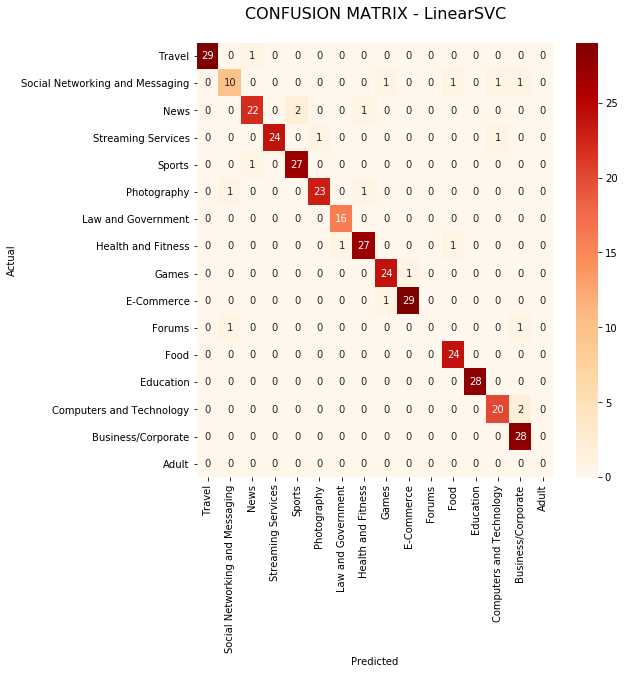

In [17]:
conf_mat = confusion_matrix(y_test, predicted,labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="OrRd", fmt='d',
            xticklabels=category_id_df.Category.values, 
            yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

In [18]:
for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >0:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual],id_to_category[predicted],
                                                                   conf_mat[actual, predicted]))
            display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Category', 
                                                                'cleaned_website_text']])

'Photography' predicted as 'Social Networking and Messaging' : 1 examples.


,Category,cleaned_website_text
452,Photography,blipfoto photo journal simple record life phot...


'Forums' predicted as 'Social Networking and Messaging' : 1 examples.


,Category,cleaned_website_text
872,Forums,aelyria forward forums welcome aelyria page au...


'Travel' predicted as 'News' : 1 examples.


,Category,cleaned_website_text
571,Travel,timespek observe infinity timespek multi platf...


'Sports' predicted as 'News' : 1 examples.


,Category,cleaned_website_text
292,Sports,liverpool echo latest liverpool merseyside new...


'News' predicted as 'Sports' : 2 examples.


,Category,cleaned_website_text
283,News,toss cricket blog english cricket spin irrever...
512,News,page find sorry find page request follow follo...


'Streaming Services' predicted as 'Photography' : 1 examples.


,Category,cleaned_website_text


'Health and Fitness' predicted as 'Law and Government' : 1 examples.


,Category,cleaned_website_text
729,Health and Fitness,safety training compliance online federal osha...


'News' predicted as 'Health and Fitness' : 1 examples.


,Category,cleaned_website_text
757,News,vet times website veterinary profession bring ...


'Photography' predicted as 'Health and Fitness' : 1 examples.


,Category,cleaned_website_text
460,Photography,filemagazine filemagazine whiten anus use lemo...


'Social Networking and Messaging' predicted as 'Games' : 1 examples.


,Category,cleaned_website_text
383,Social Networking and Messaging,chat rooms chat games avatar chat chat chat ro...


'E-Commerce' predicted as 'Games' : 1 examples.


,Category,cleaned_website_text
810,E-Commerce,port macquarie hastings bridge club welcome we...


'Games' predicted as 'E-Commerce' : 1 examples.


,Category,cleaned_website_text
833,Games,pinball mods accessory mezel mods accessory mo...


'Social Networking and Messaging' predicted as 'Food' : 1 examples.


,Category,cleaned_website_text
350,Social Networking and Messaging,pinterest discover recipe home idea style insp...


'Health and Fitness' predicted as 'Food' : 1 examples.


,Category,cleaned_website_text
702,Health and Fitness,joyous health simple healthy living inspiratio...


'Social Networking and Messaging' predicted as 'Computers and Technology' : 1 examples.


,Category,cleaned_website_text
372,Social Networking and Messaging,attention required cloudflare step complete se...


'Streaming Services' predicted as 'Computers and Technology' : 1 examples.


,Category,cleaned_website_text
177,Streaming Services,tm internet streaming media wireless multicast...


'Social Networking and Messaging' predicted as 'Business/Corporate' : 1 examples.


,Category,cleaned_website_text
348,Social Networking and Messaging,linkedin log sign member manage professional i...


'Forums' predicted as 'Business/Corporate' : 1 examples.


,Category,cleaned_website_text
880,Forums,forum thehub online forums skip navigation ski...


'Computers and Technology' predicted as 'Business/Corporate' : 2 examples.


,Category,cleaned_website_text
1212,Computers and Technology,computer repair laptop repair support brighton...
1199,Computers and Technology,network visibility monitoring solutions profit...


In [19]:
model.fit(features, labels)

N = 4
for Category, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("\n==> '{}':".format(Category))
  print("  * Top unigrams: %s" %(', '.join(unigrams)))
  print("  * Top bigrams: %s" %(', '.join(bigrams)))


==> 'Adult':
  * Top unigrams: bdsm, sex, erotic, bondage
  * Top bigrams: erotic story, sex toy, sex toys, live sex

==> 'Business/Corporate':
  * Top unigrams: investment, client, company, business
  * Top bigrams: real estate, audio visual, year experience, site work

==> 'Computers and Technology':
  * Top unigrams: software, file, web, windows
  * Top bigrams: source code, web hosting, come soon, easy use

==> 'E-Commerce':
  * Top unigrams: shipping, grocery, item, gift
  * Top bigrams: free shipping, gift card, grocery shopping, add cart

==> 'Education':
  * Top unigrams: university, science, student, chemistry
  * Top bigrams: open access, multiple choice, annual meeting, state university

==> 'Food':
  * Top unigrams: recipe, cake, restaurant, tasty
  * Top bigrams: order online, gluten free, home menu, breakfast lunch

==> 'Forums':
  * Top unigrams: forums, forum, answers, google
  * Top bigrams: share knowledge, mon dec, hour ago, post hour

==> 'Games':
  * Top unigrams:

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, df['category_id'], 
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

m = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)
m1=CalibratedClassifierCV(base_estimator=m,
                                        cv="prefit").fit(tfidf_vectorizer_vectors, y_train)


In [47]:
import os
from zipfile import ZipFile 

folder_root = 'C:/Users/hetul/Desktop/DATA'
suffix = ".zip"
s=".html"
docs=[]
os.chdir(folder_root)

for folder, dirs, files in os.walk(folder_root, topdown=False):

    for name in files:
        if name.endswith(suffix):
            with ZipFile(name, 'r') as f:
                names = f.namelist()
            for i in names:
                if i.endswith(s):
                    docs.append(i) 
print(len(docs))
print(docs[0:10])

34497
['crawled/www.gnupg.org/B2B698oFCB592B295A2tkPPEW.html', 'crawled/www.gnupg.org/8A165BCBnBADAA2082DBA904CBC0Q.html', 'crawled/www.gnupg.org/0DCA4B4R8B_10B58B903D809E2C86.html', 'crawled/rw-rw.facebookcorewwwi.onion/60iC0B2F60FL0081CD1CF0BA05X9C.html', 'crawled/mbasic.facebookcorewwwi.onion/B5C3F392kp198596BAD15C8ECBF3.html', 'crawled/sparkar.facebookcorewwwi.onion/8AM2B27F32B21C30D022287ADZABD1.html', 'crawled/or-in.facebookcorewwwi.onion/BBc_D32BC69DjNFAMDBB2L9A.html', 'crawled/web.facebookcorewwwi.onion/AF2A6qWF316F9F108A7A7BAE50EBC.html', 'crawled/ha-ng.facebookcorewwwi.onion/xA5E4094EDF892BC2CB2E4F813A9.html', 'crawled/mn-mn.facebookcorewwwi.onion/8D3A1C88T0690C3AE98kCBF30E08.html']


In [48]:
from bs4 import BeautifulSoup
import bs4 as bs4
from urllib.parse import urlparse
import requests
from collections import Counter
import pandas as pd
import os
class ScrapTool:
    def visit_url(self,contents):
        '''
        Visit URL. Download the Content. Initialize the beautifulsoup object. Call parsing methods. Return Series object.
        '''
        #headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.71 Safari/537.36'}
        import codecs
        f=codecs.open(contents, 'r',encoding="utf8",errors='ignore')
        content=f.read()
        
        #lxml is apparently faster than other settings.
        soup = BeautifulSoup(content, "lxml")
        result = {
            "website_text": self.get_html_title_tag(soup)+self.get_html_meta_tags(soup)+self.get_html_heading_tags(soup)+
                                                               self.get_text_content(soup)
        }
        
        #Convert to Series object and return
        return pd.Series(result)
    
    def get_website_name(self,website_url):
        '''
        Example: returns "google" from "www.google.com"
        '''
        return "".join(urlparse(website_url).netloc.split(".")[-2])
    
    def get_html_title_tag(self,soup):
        '''Return the text content of <title> tag from a webpage'''
        return '. '.join(soup.title.contents)
    
    def get_html_meta_tags(self,soup):
        '''Returns the text content of <meta> tags related to keywords and description from a webpage'''
        tags = soup.find_all(lambda tag: (tag.name=="meta") & (tag.has_attr('name') & (tag.has_attr('content'))))
        content = [str(tag["content"]) for tag in tags if tag["name"] in ['keywords','description']]
        return ' '.join(content)
    
    def get_html_heading_tags(self,soup):
        '''returns the text content of heading tags. The assumption is that headings might contain relatively important text.'''
        tags = soup.find_all(["h1","h2","h3","h4","h5","h6","div"])
        content = [" ".join(tag.stripped_strings) for tag in tags]
        return ' '.join(content)
    
    def get_text_content(self,soup):
        '''returns the text content of the whole page with some exception to tags. See tags_to_ignore.'''
        tags_to_ignore = ['style', 'script', 'head', 'title', 'meta', '[document]',"h1","h2","h3","h4","h5","h6","noscript"]
        tags = soup.find_all(text=True)
        result = []
        for tag in tags:
            stripped_tag = tag.strip()
            if tag.parent.name not in tags_to_ignore\
                and isinstance(tag, bs4.element.Comment)==False\
                and not stripped_tag.isnumeric()\
                and len(stripped_tag)>0:
                result.append(stripped_tag)
        return ' '.join(result)

import spacy as sp
from collections import Counter
sp.prefer_gpu()
import en_core_web_sm
#anconda prompt ko run as adminstrator and copy paste this:python -m spacy download en
nlp = en_core_web_sm.load()
import re
def clean_text(doc):
    '''
    Clean the document. Remove pronouns, stopwords, lemmatize the words and lowercase them
    '''
    import nltk
    words = set(nltk.corpus.words.words())
    engdoc=" ".join(w for w in nltk.wordpunct_tokenize(doc) if w.lower() in words or not w.isalpha())
    doc = nlp(engdoc)
    tokens = []
    exclusion_list = ["nan"]
    for token in doc:
        if token.is_stop or token.is_punct or token.text.isnumeric() or (token.text.isalnum()==False) or token.text in exclusion_list :
            continue
        token = str(token.lemma_.lower().strip())
        tokens.append(token)
    return " ".join(tokens) 
print(clean_text('vamanos much fast hello hola'))

fast hello


In [49]:
import os

def get_filepaths(directory):
    """
    This function will generate the file names in a directory 
    tree by walking the tree either top-down or bottom-up. For each 
    directory in the tree rooted at directory top (including top itself), 
    it yields a 3-tuple (dirpath, dirnames, filenames).
    """
    file_paths = []  # List which will store all of the full filepaths.

    # Walk the tree.
    for root, directories, files in os.walk(directory):
        for filename in files:
            # Join the two strings in order to form the full filepath.
            filepath = os.path.join(root, filename)
            file_paths.append(filepath)  # Add it to the list.

    return file_paths  # Self-explanatory.

# Run the above function and store its results in a variable.   
full_file_paths = get_filepaths("crawled")

In [50]:
len(full_file_paths)

48695

In [70]:
webtext=[]
cat1=[]
prob1=[]
cat2=[]
prob2=[]
name=[]
c=0
for i in full_file_paths[20000:]:
    try:
        scrapTool = ScrapTool()
        web=dict(scrapTool.visit_url(i))
        text=(clean_text(web['website_text']))
        webtext.append(text)
        t=fitted_vectorizer.transform([text])
        cat1.append(id_to_category[m1.predict(t)[0]])
        data=pd.DataFrame(m1.predict_proba(t)*100,columns=df['Category'].unique())
        data=data.T
        data.columns=['Probability']
        data.index.name='Category'
        a=data.sort_values(['Probability'],ascending=False)
        a['Probability']=a['Probability'].apply(lambda x:round(x,2))
        cat2.append(a.index[1])
        prob1.append(a['Probability'].iloc[0])
        prob2.append(a['Probability'].iloc[1])
        name.append(i)
        c=c+1
    except Exception as e:
        c=c+1
        print(c,i)
data=pd.DataFrame(list(zip(name,webtext,cat1,prob1,cat2,prob2)),columns=['file_name','Cleaned_text','Category_predicted',
                                                                         'Probabiltiy_of_category_predicted',
                                                           'Category_2','Probability_2'])
data

4 crawled\l.facebookcorewwwi.onion\C9190AQI20E7A6F6C3B50266087z.php
10 crawled\l.facebookcorewwwi.onion\C9D2-WD0pCAc5E1D1D3DeB1KF5.php
14 crawled\l.facebookcorewwwi.onion\C9zZB925pBxA2N1D5DCwjF3.php
19 crawled\l.facebookcorewwwi.onion\CA90C1MlBh82CFovEA194089.php
31 crawled\l.facebookcorewwwi.onion\CB3AA2sep87B2B9D97Fk8DD1261FD905.php
35 crawled\l.facebookcorewwwi.onion\CB7mzzD8D18E33C1B889EFCgDA.php
53 crawled\l.facebookcorewwwi.onion\Cd140628u1C15P109DA2CBB5ABx.php
68 crawled\l.facebookcorewwwi.onion\Ce2020M1BAC89984BF9yI24FA.php
85 crawled\l.facebookcorewwwi.onion\CFFE89E0mB1C2B6X4872Cgx6C5.php
99 crawled\l.facebookcorewwwi.onion\D05DCPO3FA89CE50C88W1C11BD6.php
104 crawled\l.facebookcorewwwi.onion\D0B0b3DC2B820B27DE0CF016H24.php
105 crawled\l.facebookcorewwwi.onion\D0B9A8AACB89073FDCBFCF310B15-.php
118 crawled\l.facebookcorewwwi.onion\D1DAA3TBCA387B7g07B894CFDAPC1.php
119 crawled\l.facebookcorewwwi.onion\D1DADpD5k11C2Z9BDeE5CB21D1.php
124 crawled\l.facebookcorewwwi.onion\D203C7CB011

1215 crawled\lm.facebookcorewwwi.onion\CC5CB7D3Z16A99804K7C277FeCBr.php
1216 crawled\lm.facebookcorewwwi.onion\CE80E939B1718C214D0BDD4A225B783.php
1217 crawled\lm.facebookcorewwwi.onion\D214ZTEFA9lFErCA5BA124113E88.php
1218 crawled\lm.facebookcorewwwi.onion\DB11D99418C4091D0A3FB88D59DD190.php
1219 crawled\lm.facebookcorewwwi.onion\DE07bAB3EE5DBC289CA009D22898D5.php
1220 crawled\lm.facebookcorewwwi.onion\E7CF88_rQy8140EE298AF29722J.php
1221 crawled\lm.facebookcorewwwi.onion\EB7DB228211A712C5AF-7BBCC1xn.php
1222 crawled\lm.facebookcorewwwi.onion\EB94D1DEECA004EF3DR9925ToD7C2.php
1223 crawled\lm.facebookcorewwwi.onion\F5D9P8B1D95E20707DDE4F9DE9ECFP.php
1224 crawled\lm.facebookcorewwwi.onion\F99D310ii12D5sepb9A14AC9A18.php
1225 crawled\lm.facebookcorewwwi.onion\FA16DCOE7ZABoB1EA1C178C1E75B.php
1226 crawled\lm.facebookcorewwwi.onion\l1DO7B04B093Y0Dg21F8i22CDg.php
1227 crawled\lm.facebookcorewwwi.onion\Md19d5-ABB5F20FB9BB8E7B026.php
1228 crawled\lm.facebookcorewwwi.onion\S9C6DD9CFA5C5gE3eAEB

10849 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\05-8416D510A4ED8CE15V9DC5B7AB.png
10850 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\05186A301FD15F6DBsep88D7QD0F113.jpg
10851 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\055BwDEC7YF1FEE93E7BC7E1sepv.jpg
10852 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\055C14F5A688D719B6F91F2A60B4B22A.png
10853 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\057BBP99W159FB61FvqJB2248A.png
10854 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\0593PN3BF62208C73BPC1DBF294sep.jpg
10855 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\05A8D5686iADC4K80FBD4EDDM.jpg
10856 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\05bE3C_9ED7FCrCAE6A0vKAC96.jpg
10857 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\05F9AE5EBF16C6fK-60nA2E9-8.png
10858 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\05Q0E4eiD213D0ED0E3DsepnQo.jpg
10859 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\0610DBCf91A9z1F8BAF25FAE681B5.jpg
10860 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\0616e870D20E20784A9A402C12E3AF.jpg
10861 crawled\

10957 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\0DB3001CD5oBDB5iD8D9l82A2YE7.jpg
10958 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\0DC1F1ADB18VCE9FFC386AE9824C9.jpg
10959 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\0DDA3098BbD3A0EF722sepDDsep18A2.jpg
10960 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\0DLB53D8880O93B6F0ZnBDF4EAFA.jpg
10961 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\0Dper90fBA1F7BB0CB2991ACE3EAF5E4.jpg
10962 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\0E04DaEV26A387ZE483D883A204.jpg
10963 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\0E15uC9F2G8491A8FF3D893CBBEBK.jpg
10964 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\0E191640C7CA890BDAB6ACC8880EC3B.jpg
10965 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\0E2588t20DE5E_E2010DD0-BD9F5C.jpg
10966 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\0E3ECBiR18B81CDCBEpCFB9y96Y.jpg
10967 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\0E560E18D2902zF51B17d0AF200r.jpg
10968 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\0E7DDED9C3A8CRaA291BB9FC5BAFC.png
1096

11057 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\17B1EBF0DBE3AEy14B91CA2198eDA.jpg
11058 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\17D4lE4sQ2302A3per5D08C600A1B.jpg
11059 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\17F3F2oS9FB5A6Zp84d8EA718W.jpg
11060 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\17KFB1F21K7BXDF6004KSB384A2.jpg
11061 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\17N12sepF9E2PC242397eA8F18BF.jpg
11062 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\17_1AE6GEF1791wWBE7DF0C01524.jpg
11063 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\18011AFFo919D8D13999713C4B1x16.jpg
11064 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\180CFPD81BP7BD6D2W8FDF1C3Ci.jpg
11065 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\181982F2BaZ1803D8B0DB869BB6w.jpg
11066 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\181A8F589D68FZ983DFED3cC594.jpg
11067 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\182B213D9F1C2D5F3B722212WCA2C.jpg
11068 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\1887D42785F9e4kACEDu1FF206h.png
11069 crawled\sco

11164 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\1FsepB88FC0B604F4CCh8AA5bj0587.jpg
11165 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\1r190B9AB7C3FPB987bFC3E1416.jpg
11166 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\20-1553D80CE494CB1BACAF05r90.jpg
11167 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\2007XyQA0F1B888705U3FBC81U.jpg
11168 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\20115E2884E0AF1DnbUD198D62C9A.jpg
11169 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\2015E4yZ96VED89D1CD5E3ErpF8.png
11170 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\202100DF7DD9EF93B7V1DKFF517EA.jpg
11171 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\208D94CBF1E41512E08F0eA8v8005.jpg
11172 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\209CYA21900B68582E0BC05sepFE0k.jpg
11173 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\20B30327B2250CF4DA5C4mBANC3E.jpg
11174 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\20CA90U979T1CsABH179DBFC727.jpg
11175 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\20CdL07PeDBD0A289EAFC998BA8.png
11176 crawled\s

11265 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\27QBD170F125E5EFD140C7oC809sep.png
11266 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\280823C708D2823DE7Fu8Aa23.jpg
11267 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\286b0E20DC7F60AK00TmAFE0C3.jpg
11268 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\28A3F14BA5DC6F9F5B9F3B485tcN.jpg
11269 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\28E4A1C93F0BX271BC7A7S983E8D0A.jpg
11270 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\28F2e1C80v3E2CA90mbF19FML.png
11271 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\28FDE3l17B18D3A19BE8D8887C886B9.jpg
11272 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\28oE2HB1BA989U98EE6046NCD.jpg
11273 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\29-11e23C0per1080DW3F123AC0A2.jpg
11274 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\296A098940E00BA89AEDDf091D40.jpg
11275 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\2986117BF75Bz1EwF5CB8003F5DD6.jpg
11276 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\299DF3C3D13F8DF53F0B87dB5B17CD.jpg
11277 crawled\sc

11367 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\3E5E92C912eE49E9AA09BfA0ED2792.png
11368 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\3E8CIl1En8FvD90ADO92990Fi.jpg
11369 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\3E9412873B409EC13weS941694r.png
11370 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\3EA3C9DC48CB6CC7F55BFF02DDK29.jpg
11371 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\3EA6E2RE0F5ryp14UA9832302.jpg
11372 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\3EC6157C815BF3lCA875Ee5DFBE30.jpg
11373 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\3ETe1EEC92B00sN13P9824IE1.jpg
11374 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\3F19018A94060E0CA6A225A61E109E.jpg
11375 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\3FA65D2899FDC6CAE09CD2AFCAOs26.jpg
11376 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\3FD89F22T3E7F91CF294187D214B7.jpg
11377 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\3FDC50C_ACtxEDD0D11AEA2j3D.png
11378 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\3FEENCBE7BCHF93B85F2EAFC1D3BA0.png
11379 crawled\sco

11469 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\6DFD4CFD39FZYBC10C291E82E1x.jpg
11470 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\6E0F1lCC-109DE3FU97C94BFF8.jpg
11471 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\6F0bx1E93X04E8FFE5D2UFE2217.jpg
11472 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\6P8195sepT87E6fDF270DF1B38A2.jpg
11473 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\6q6027B2s978E1oP81RM3E90.jpg
11474 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\6ZAAF43DFD91HC683CF5DhC7921E.jpg
11475 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\70C89l9722B3C7045B157DC69660sep.jpg
11476 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\717F7E4E023sn9BwmB2EA96E7.jpg
11477 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\71ED0AB8A2AD8CA499QperEBA9A9T.jpg
11478 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\726AFD0B8BB4F994DE1BBEB3A23F1E.jpg
11479 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\73BE67DvF1m23D28E416C14DBv.jpg
11480 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\76009C8F29pE17DA56EAE90E9EB2.png
11481 crawled\scontent.

11576 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\83TE3l87BBE3tM29yE61FB1D0FA.jpg
11577 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\840Ebbl0D7A3BD0AD75B89ACTW.jpg
11578 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\842CCF1390B8GB44181FAD2892KF9.jpg
11579 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\8491qC489ACAD0808B067B94RB594.jpg
11580 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\84BF5A226D6E3Y1F99B6gB2141BB9.jpg
11581 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\84D8FB123A0A0CFwBD9CmB2B8C9D9.jpg
11582 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\84E40AA816_B1B2B80EVBFxE3C2F6.jpg
11584 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\84HCF0402d9AA99A6BCEAEDD2D560.jpg
11585 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\84Kc05D98DBE12BB58CF182T0416.png
11586 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\84MWF0FAABZ8EC0DNDC40f8F7.jpg
11587 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\84t5BAB80s-1FCFD5A1V9D8995C0.jpg
11588 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\851FAASQC192OC1i5Ex1BECz1D.jpg
11589 crawled\scon

11678 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\8C8E0EOPhB4A111h95A5zFEHk.png
11679 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\8CA7D6B81D8693BFD6v-cC3BE0386.jpg
11680 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\8CB98A921DDAj1A8F2ACACE609687FA.jpg
11681 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\8cDA98DF7B23CEsep1621CBBDB3WG.jpg
11682 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\8CE21FkaAEoC5EFFE41082iC129.jpg
11683 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\8CF2B171BAF2oBAL8A7E225A307.png
11684 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\8ChD9B19EBAAF255C23B5x0319w11.jpg
11685 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\8CN9E079C7CEECB23D1897601CA2D1.jpg
11686 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\8Cq1616FC88R0CC6CDRDiPDAD3.png
11687 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\8CSB30DperTAE9F8FFF87BB15BBCFs.jpg
11688 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\8CwY7D9CE7C95K9DBC6F6hK18.jpg
11689 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\8D0913h153FFBBE19hAF178EDD8.jpg
11690 crawled\sco

11780 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\939BF59ECDuQ9AAA01ECaD3A85p.jpg
11781 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\93AF63FA0D5D1296A7sepc112BE88.jpg
11782 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\93DAE6VC5ABAB83B385D50D08C40y.jpg
11783 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\93DF407B8B61BF23fB20B02F5qN.png
11784 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\93E77F0FE63AFC96jC31EC6YHdE1.jpg
11785 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\93F119AEC60B0AE94W26LOE2D90E.jpg
11786 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\93F2D0jCAF9WEBEDB2A0C808C822A9.png
11787 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\93RD9C88BF93F271EDA84214C5ECAB.png
11788 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\93yB860CDCA8A8D27BC9DAAE0A481x.jpg
11789 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\93yO85N9EB45B96868984L84nF5.jpg
11790 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\94278DCE697perLF282P7B28WPG.jpg
11791 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\943EUD10AED293C5101BF4BE997.jpg
11792 crawled

11882 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\9B8VBCB69BD49AU85H08PA0_O.png
11883 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\9BA2CA85A79785s87CL3CEDD31E.jpg
11884 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\9BA817E6EF29E1B5C1eH968CA71A.jpg
11885 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\9BAB3D1525_vD0CAORCC85CRFF.jpg
11886 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\9BB08BE7KFAD240BAB8wvB9AAB40B.jpg
11887 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\9BD8o09CC2A1C14T8C89B8F8D9E41F.jpg
11888 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\9BDEwAF1B85CBqV8tzkCFB6D7.jpg
11889 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\9BFDxEE15BD898A17BDF5EFL1D98BE.jpg
11890 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\9BQBB18BC00-A3C1CF408A8F15qW.jpg
11891 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\9C085E0e7Ft839EC7PC03B59A21.jpg
11892 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\9C7FQ985969DA8C1050B01ACA0_E6.jpg
11893 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\9C8Fm2j_5D3EA67FA5D99AF3BFD1.jpg
11894 crawled\sconte

11983 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\A4T8E7AFA3B1DDZ8088D8F05perBD.jpg
11984 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\A504sepAC4B2C9D79D181CADE6SB014.jpg
11985 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\A517AAD442CDBX08FB038ExC188m.jpg
11986 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\A5295DDE79ASU94A1D260B3A09AE.jpg
11987 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\A57BTECEq207B18W09B9kC27B8.jpg
11988 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\A5AAjB6BFnB5FF800D82W513eCB.png
11989 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\A5BDAC5C5EDC4g0D3E5D7AFAB28D9.jpg
11990 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\A5EB239CF4E10FFE7CX1C57D9740.jpg
11991 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\A5F100C5B0E78117BB99N7F1F0B7C.jpg
11992 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\A5F57888194q1FF1X3B7BB20407AE.jpg
11993 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\A6038DADCD25C1FDE433D0395cC721.jpg
11994 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\A610C_B4E6SEgDDE7aBC0DEB7F.jpg
11995 crawle

12089 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\ADB9RE6C4B569EE7AAQAFa820A05.png
12090 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\ADC3C080i3BF4E2sBED2N8D4C409.jpg
12091 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\ADD5F2AEE0F0F7K9E811895FBB5wt.jpg
12092 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\ADD8BB82PED089DkA22C8CA050DA.jpg
12093 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\ADD9CFG0AF1GDFB100M11C3ACC2.jpg
12094 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\ADF6A3CEVsv24WAFDBD9B2ChCB.jpg
12095 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\ADFAB77CF33D1814F3FDDA1209FDS.jpg
12096 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\ADj90pA5DFE0q8BpY0AF12A9C.png
12097 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\ADl2Cm2759AEE6zFFF8AFD6h.jpg
12098 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\ADl5CD7OXB8bEF85E796GB2per8.jpg
12099 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\ADlFvc40A487m0DD19FQEF8E8D.png
12100 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\ADyC724FB16B63C297FF4qBC2CA78B.jpg
12101 crawled\scontent.xx

12193 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\B5P7CC6F9E982iE85B0C9D0Af680.png
12194 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\B60491DA06gys1E9AQ1A2x00A8.jpg
12195 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\B65CDBD5DED58Cv5El06F2zF22A94.jpg
12196 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\B685Um0B058521b8FD2E5FB7E0FB.jpg
12197 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\B68F20CE120D4CDBFA5E459ADC185.jpg
12198 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\B6DC9AB2AF13B1DBB3209C23CDA4DB.jpg
12199 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\B6oC599DED2F51560BAk0AB5FBJ16.jpg
12200 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\B6per8F9S91F1B25Cper88ED9D169EC8.jpg
12201 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\B707CB3FD2CFEF1923A3FtB117828E.jpg
12202 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\B73D0B87BC89tFBA93AA5GAB822A7.jpg
12203 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\B785E9ZA30E7FzDB016B61C309L.jpg
12204 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\B786C9hmd96nAA3C2AF0C5A4D6B.jpg
12205 cr

12300 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\bF723A23BE1F883A97FC18DdBCBE.jpg
12301 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\BFa159ED06EDB2pA2dC2B614CFF.jpg
12302 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\BFE7aDA2892c9D08E19Cp95E795DE.jpg
12303 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\BFNgBF9D379De80N9AF508D1FD.jpg
12304 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\BFQx8BAAEFBF3ED2tE8F93B19B7z.jpg
12305 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\BFz1FD0F23Ci23DA1EUCDu95D5k.jpg
12306 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\Bt08BBw0105uwD3E00EC0926BB.jpg
12307 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\bv3E5B06EDA1CDwFDL608DlBE93.jpg
12308 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\C003883DU9C24D7CFF5vj1A15DCEB.jpg
12309 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\C0177BDAA490D07DFUB8BC0F4ABCC.jpg
12310 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\C0D72786DFF17233C81DDqIpA8K.jpg
12311 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\C1006118E185EC198pgwm3E94DC.jpg
12312 crawled\scontent

12402 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\C8E4CA6D8838CA7FCB9B253DEFNF4.jpg
12403 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\C8ECQD68986A38-8AyF8VGE9W.jpg
12404 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\C8jDA29D7CEE5D5A226y21wECg3D.jpg
12405 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\C8nFBEFC1A27F3BDCFFABB2sepC6C9.jpg
12406 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\C8o92328CCpA2EED2D6BsepC19686.jpg
12407 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\C9018540CB0820-010CFD4EED1831C.jpg
12408 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\C901DB05l1IA011014A23ED0H25.jpg
12409 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\C9161DC189267F90C3CAi87E2tW4.png
12410 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\C921110D2B90C70C8A9DB2B4p09-A6.jpg
12411 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\C9835Bz-CF0BJ7CEA804B0CEoC0.jpg
12412 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\C99B8ACBDB19FB22D8C5m4n3FmI.jpg
12413 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\C99FI0119E7B5U97CB2AD3AlC224.jpg
12414 crawled\

12506 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\D0DEBE4DD92898FCFlF6j29228E0E.jpg
12507 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\D0E89BFCB7BA83830DE95D211CD59F20.jpg
12508 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\D0E97F9Zzm4075DDFF7Po95A7.jpg
12509 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\D0EEPU02E22AHE8tfDC067D87CE.jpg
12510 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\D0nED3F1F101991aC3perEDD1-99BF.jpg
12511 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\D0ZF2BB95GD9BCW1BFF3BD47BF0E3.jpg
12512 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\D1109C05EAF8A9bfA25CL1Ao0BA5.jpg
12513 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\D111W90DA5DBC0Fx8A22ACA8E0D75E.jpg
12514 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\D112FAdG5CtqbD22C9EEDACN7.jpg
12515 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\D1133D1AE83BC282RC4C49222E6DB8.png
12516 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\D129N1CBF92C6EEC9721AFD8EC2C2.png
12517 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\D13ADE83B3zDDFC84EFx9C8TA0E5.jpg
12518 craw

12614 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\DAB02BD58B2C2C80DE90Dn2982E0.jpg
12615 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\DABBEE0419C0F9F96D6E4CAC4ZDBF5.png
12616 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\DACA0060RG8C1E2885BAB9E2DBC1E.jpg
12617 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\DADC1326SEBEDEcaC8lDBE1F797.jpg
12618 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\DAEATperE909B695D58DZAFC7U-CD.png
12619 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\DAFAF798KB35DC49C3B9F8A84fYB1.jpg
12620 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\DAFE9988E7E39ED02A24C8254w9E0.jpg
12621 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\DAtA9OB2CBA86_6021lNuEF9B.jpg
12622 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\DB08nLEF84DF2996iZA4F7e05E7.png
12623 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\dB92804E269D93CF26EETE4F3G8F.jpg
12624 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\DBADE0A0BA8D3A120260B9HHsep2602.jpg
12625 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\DBB2b1B037D1D9CDA7FD83D25C9907.jpg
12626 craw

12721 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\e0FT5AE1BB0jaEq17DF068C5C.png
12722 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\E0I01177CBAe09Z7FFCyDBCA9AEE.jpg
12723 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\E0w5D9-F4-040CEFCDC15SAF.jpg
12724 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\E11D0819sCFA4jBBFANpjA70CD3.jpg
12725 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\E11DcBB198C93wF2F4FE5E15D80FC5.jpg
12726 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\E11EB2qh078C9697x24B02BACD7EF.jpg
12727 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\E126EA0490D8bF5E9j035DA5per1N.jpg
12728 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\E13287F11F1E6079C13B19088Dg1C.jpg
12729 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\E13C87ECB78DCF1DBB49AO3DA403DB.jpg
12730 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\e15EAE818DEC00805CDABBB30994A2.jpg
12731 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\E181A9B49Bl89DBCF1895A98EF6B78B.jpg
12732 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\E18411D0FC5848BEAb2CE3BBN02Q.jpg
12733 crawle

12830 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\EB8AF4A7bC88D26D65BA33FAF02E2.jpg
12831 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\EBBEE707O0E8509ECxLAE941F92B2.jpg
12832 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\EBC5D2gFF97F73AB88D8BE7298F9497.jpg
12833 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\EBC9400EN16A0E55F59D8DEB92DCsep.png
12834 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\EBcCC7WDBFC88ED7D8ECA3E8ABB0.jpg
12835 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\EBD6CE_2C7D861D821C169C3DB5j1.png
12836 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\EBdiHC53BCB98DE6CD8B8A8perF2.png
12837 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\EBf6AFeE1202513EEFS03hC809.jpg
12838 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\EBjAE0BA626H26D7B3E2E408VB060.jpg
12839 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\EBMB078CF30310AEFF95C9031588E8.jpg
12840 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\EC123CE02CECDE96mFCC1D76281DC3.png
12841 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\EC1418AF3l225BF595ECAFCE9BA6u.jpg
128

12930 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\F4BF1F3AXDF7F8BsepeID50A849FFB.jpg
12931 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\F4D6v5C15CEC0rHC4ED835B8F2An.jpg
12932 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\F4E8x29FDF7A0A019YE37DB0CEoD0.jpg
12933 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\F4l2BvDEBR21NA4D5DBFFC8B0z.png
12934 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\F50BDDC81B0C16FA10kF6E960BE249D.jpg
12935 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\F514B588A1CE6FCD8k93ACEC8A8L.jpg
12936 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\F5208B01pN909AO0E2704F1DDE1B1.jpg
12937 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\F528ph2E2F2FE5DEF2HBBperN14.jpg
12938 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\F52A1CB1BB1Cper9DF0CBDC98488B.jpg
12939 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\F586C7T12EF3F1397E507KJK92per.jpg
12940 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\F5A4TC78CF8F5B72B828C0592lp82.jpg
12941 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\F5D20EfB108C2EA3F9190188D3CE0X.jpg
12942 c

13039 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\FDK05BB9053E29CAy075DB613BFD3.jpg
13040 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\FE0C006AF9AaS0EE6D07BECA4T10.jpg
13041 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\FE17C52AH1521C2mCAA7096WE2E4.jpg
13042 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\FE3BBD82AA9300X3F5E927BzQO3A.jpg
13043 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\FE723F0B3ECACB707914DA492A82.jpg
13044 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\FE8095E3A8EDsepC20ECA2B99BDB4A95B.jpg
13045 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\FEB5q08o12T9EB93E1DBF3D4CAx.png
13046 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\FED3X7BD9987DFBA6GB481B4AEBm.jpg
13047 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\FEDA-8800E61C18241127CE5EC89AC0.jpg
13048 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\fEF4o13FA6C2A82620C6VLB915.jpg
13049 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\FEwC5BD90AA9C15D3F5A9A825QDCBE.jpg
13050 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\FF4995D1AD883ECA3TF6rA2AF10n.png
13051 cr

13144 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\K15B4C7E6R990F8782A8msQ8CC3.jpg
13145 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\K25B6ODDE3D80B8A617sepSA114.jpg
13146 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\K60E124BFB8D718107D0BB61A7M.jpg
13147 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\kB5A3C7D3cD51EFC9CA718C07AB.jpg
13148 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\kBEE6zA3KAF80E0DF12T93CF949F.jpg
13149 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\kBFB31ED85CDB8DF6F218FC06nBEA9.jpg
13150 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\kC2D5DC11NrjsEDB2CxjQ8B.jpg
13151 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\KC48F9D7C720AAC07123EjCEiQ.jpg
13152 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\KC5D406DE06EArC13ErE87D88CD.jpg
13153 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\kCD8928F4140BC90421zp1723K.png
13154 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\kD186B5EF1B907C0BBBB2ZD4CCFB6.jpg
13155 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\kD9-C9E1D9F7EB7DyCDFA9701V.jpg
13156 crawled\scontent.xx.fbc

13249 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\P18C0D8FD55E8DCB9_F3D69BA2k.jpg
13250 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\P1E94DFDA80D0A508A912C3DDUCD5.jpg
13251 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\p2686NCEA5r84F424248523FAE4Z.png
13252 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\p290EF7KR3DG86D9E9ADBFB00F4.jpg
13253 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\P29CD60E6iz3DBEgW7D98BFM-.jpg
13254 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\p3BF8Z9A02UnC91CDFCBperD85C07.png
13255 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\P3FCFEFE3D226090402A02oF2DF.jpg
13256 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\p5118798B8098DAE3150C1AB8AC23.jpg
13257 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\P9b25H1827y19VA4cEEB4D74.png
13259 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\PB57D16E58515C1sA729EE08W1AE9.jpg
13260 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\pB69BhF29627asB0FXABC7965C.jpg
13261 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\PC9131C15e21-2B7C14AF7FE9497.jpg
13262 crawled\scontent.x

13352 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\tXB68A3FU9C24911F807E703EFAA.jpg
13353 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\u1188CF25BB3F5_5E02FCBE1D17t.jpg
13354 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\u20E0AB19941104perFAsAFADDC3.jpg
13355 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\u252B85C7XQC3S805EorbDA03.jpg
13356 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\u2C5CE9C1X7BBA120FD6B2a3EE3A.png
13357 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\U3Cc-13xA7M41EL3A7DC81FBF.jpg
13358 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\u8600I141A162BCA8FQAdA1per5.jpg
13359 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\u86i40G9C18957B071E9Bg6AE.jpg
13360 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\u90E5BFaB2AD17D1877B1D809EFDu.jpg
13361 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\U94_D6490A2F1E9DA3A-usepJw.jpg
13362 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\U9587NF55959ED13AB99A4C1M3.jpg
13363 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\u9F03DDAsepF1IA8C6401C3EpA8E5.jpg
13364 crawled\scontent.xx.fb

13453 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\Y1617E28DC507F29A95D4F493-8717.png
13454 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\y1FAC8B3B4160A21B69AA283200.jpg
13455 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\y224F3D819D0S81F6T825C0ELd.jpg
13456 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\Y29E3DE3E5lA606F9E3CCg22EDc.jpg
13457 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\Y2CED0W915281A0323C0048FE9E.jpg
13458 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\y3DCE8D95U2CE7E4129xA2BA3BA5.jpg
13459 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\y82C3D94ADmD7BADF8390F8DFBD0.jpg
13460 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\y90FFF605PBC8A82780E5EkN09.jpg
13461 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\Y99AB4A7D0B5uCEBAC920B2706.png
13462 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\y9C5D02AF89024sB6F3CEC7A6F8D.jpg
13463 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\yB1BDUB7E293BECDF5CB4123CADDA.jpg
13464 crawled\scontent.xx.fbcdn23dssr3jqnq.onion\YB3EEsepC6201CC9D57CDD8AF989oF6.jpg
13465 crawled\scont

13934 crawled\static.xx.fbcdn23dssr3jqnq.onion\0E0F440EBB5888CT16D7A1ZC5t1B.css
13935 crawled\static.xx.fbcdn23dssr3jqnq.onion\0EA3B1B69189A3BFA8B7D3pC3293FEB.css
13937 crawled\static.xx.fbcdn23dssr3jqnq.onion\0FCDVC4A5C0600F-m81UADALA1.css
13938 crawled\static.xx.fbcdn23dssr3jqnq.onion\0mF0A7SBBE6B18F7041587JF0E.gif
13939 crawled\static.xx.fbcdn23dssr3jqnq.onion\100EE28DB3C3F907KD41NSc8DAD.jpg
13940 crawled\static.xx.fbcdn23dssr3jqnq.onion\1025A963CA5C9B3C59D0FBN9E9F12.js
13941 crawled\static.xx.fbcdn23dssr3jqnq.onion\102CsAC298B3DT514lG9FBEE7.js
13942 crawled\static.xx.fbcdn23dssr3jqnq.onion\10A251ETDDEDGE51E08F15E10B8o.css
13943 crawled\static.xx.fbcdn23dssr3jqnq.onion\10B3Cns3FfF304DDD8EC3IwC2.png
13944 crawled\static.xx.fbcdn23dssr3jqnq.onion\10B8v8A8B0A5pero01DEE791F488ED.jpg
13945 crawled\static.xx.fbcdn23dssr3jqnq.onion\10sep9B29B9BFF9z9DC4FFR0DFAXd.png
13946 crawled\static.xx.fbcdn23dssr3jqnq.onion\11237CH99DB211D269AA82290D01B.png
13947 crawled\static.xx.fbcdn23dssr3jqnq.onio

14048 crawled\static.xx.fbcdn23dssr3jqnq.onion\5BACA86A4fFF8913FEAA9AD2n1Dy.js
14049 crawled\static.xx.fbcdn23dssr3jqnq.onion\5BB7_85D1C2DDB412C5BF21DEB7D416.svg
14050 crawled\static.xx.fbcdn23dssr3jqnq.onion\5CperA7F25C2CF5BA28F3J82DD1A20.gif
14051 crawled\static.xx.fbcdn23dssr3jqnq.onion\5D3E047cD1FFF80A9F1DL18D5J22.js
14052 crawled\static.xx.fbcdn23dssr3jqnq.onion\5EBA8D9A97YD097D97F107FF2a80FF.html
14053 crawled\static.xx.fbcdn23dssr3jqnq.onion\5EBBP92Y5133F83rsE2292C3u.css
14054 crawled\static.xx.fbcdn23dssr3jqnq.onion\5EBBRmB2C405Y250A85REEA0C6.js
14055 crawled\static.xx.fbcdn23dssr3jqnq.onion\5ECFc3387E1v9Aper26A5CA820719.png
14056 crawled\static.xx.fbcdn23dssr3jqnq.onion\5EXk222T82D088A7P1Cos920A.css
14057 crawled\static.xx.fbcdn23dssr3jqnq.onion\608s8PAD1Bl960FD699B1E2a2C.css
14058 crawled\static.xx.fbcdn23dssr3jqnq.onion\60DDE4FCe0GA7ACo075BdF8Il.png
14059 crawled\static.xx.fbcdn23dssr3jqnq.onion\6AAs3F16B55DAB809EEEF98560EA84.css
14060 crawled\static.xx.fbcdn23dssr3jqnq.onio

14162 crawled\static.xx.fbcdn23dssr3jqnq.onion\9FXB11C04X876L8AJU89c8815.jpg
14163 crawled\static.xx.fbcdn23dssr3jqnq.onion\9FZYFB22W940914d81FC901F28A9.png
14164 crawled\static.xx.fbcdn23dssr3jqnq.onion\9L5E872A19A8D7ULh2a7CA9B.js
14165 crawled\static.xx.fbcdn23dssr3jqnq.onion\A080AA2BFf2T0D7F0306A595FD2.js
14166 crawled\static.xx.fbcdn23dssr3jqnq.onion\A082A3E20D04C8E2A1BD8A881C8AF4DC.jpg
14167 crawled\static.xx.fbcdn23dssr3jqnq.onion\a0ABF7E5C881EFC9A4F5DCE0D60FF.html
14168 crawled\static.xx.fbcdn23dssr3jqnq.onion\A0AD8fD23FE4O98BD3BD9q5E7CC5.css
14169 crawled\static.xx.fbcdn23dssr3jqnq.onion\A0AE98BFqrBA83FFq14DEAE9CV9F.js
14170 crawled\static.xx.fbcdn23dssr3jqnq.onion\A0B2C682A2AB89F8k99eE43B8-w.png
14171 crawled\static.xx.fbcdn23dssr3jqnq.onion\A0FBB83CIA47D1D4FF3DBFm3E0D81.css
14172 crawled\static.xx.fbcdn23dssr3jqnq.onion\A0N3B07E133E50383822D5B729t.js
14173 crawled\static.xx.fbcdn23dssr3jqnq.onion\A0u8027BEBJF5AE0FD1E0p9DD323.css
14174 crawled\static.xx.fbcdn23dssr3jqnq.onion\

14267 crawled\static.xx.fbcdn23dssr3jqnq.onion\bN514BDjCBF8jB3B4CC4097b01.css
14268 crawled\static.xx.fbcdn23dssr3jqnq.onion\c-5B893A95A951240AA22E2AC1E87.js
14269 crawled\static.xx.fbcdn23dssr3jqnq.onion\C00A25E0VD1218D0C93O12BFB8AAs.html
14270 crawled\static.xx.fbcdn23dssr3jqnq.onion\C09CE3E8v25A3205CF43EbCB12BDEA.js
14271 crawled\static.xx.fbcdn23dssr3jqnq.onion\C0DC2E0kabA3BBIFD82B7ADC2Z.png
14272 crawled\static.xx.fbcdn23dssr3jqnq.onion\C0r80D7F5A59A22C16F719CADFF17.png
14273 crawled\static.xx.fbcdn23dssr3jqnq.onion\C2BC5E816D48FADFC8216zRD4B4E7.png
14274 crawled\static.xx.fbcdn23dssr3jqnq.onion\C2StFDE0CCA525xEBYsepa0FI2C.png
14275 crawled\static.xx.fbcdn23dssr3jqnq.onion\C3DBEC85nAA087BZ07YEB03BA7B06.png
14276 crawled\static.xx.fbcdn23dssr3jqnq.onion\C3oC86DCa80B0E291DA61CAi06.js
14277 crawled\static.xx.fbcdn23dssr3jqnq.onion\C3RF7D2BC97F67BED3AcDBA1FC87k.png
14278 crawled\static.xx.fbcdn23dssr3jqnq.onion\C4DE155DCD5DA49BAB09B85B15C7FDD3.css
14279 crawled\static.xx.fbcdn23dssr3j

14373 crawled\static.xx.fbcdn23dssr3jqnq.onion\E39CpE2F324DBF79D1A7Dea097n.js
14374 crawled\static.xx.fbcdn23dssr3jqnq.onion\E3A5828DvE0DF5BiD00F08AE21AABC.css
14375 crawled\static.xx.fbcdn23dssr3jqnq.onion\E3ABzN3B8A7A829BAqC7FF8AC8AE.gif
14376 crawled\static.xx.fbcdn23dssr3jqnq.onion\E42CsECHF60FF0CA3BB2B8A8sep3FC4.css
14377 crawled\static.xx.fbcdn23dssr3jqnq.onion\E5C3T14E90CsC75BCB5B17AFCEFE.png
14378 crawled\static.xx.fbcdn23dssr3jqnq.onion\E600AjPK29F2D7pFB17D43E2CA7.css
14379 crawled\static.xx.fbcdn23dssr3jqnq.onion\E6901112N9CA8E4EBE10DD0tCCDD1.js
14380 crawled\static.xx.fbcdn23dssr3jqnq.onion\E697UF19EAAE8LG24A9EE95ED0CAC.png
14381 crawled\static.xx.fbcdn23dssr3jqnq.onion\E699TD2259C92tDDD7AAFCi23b00.css
14382 crawled\static.xx.fbcdn23dssr3jqnq.onion\E6BCACperDD01ZF5qF88292C49A9BB8.css
14383 crawled\static.xx.fbcdn23dssr3jqnq.onion\E6zF51E8B3DkCFC7B8AE1Ehb96B6.png
14384 crawled\static.xx.fbcdn23dssr3jqnq.onion\E703B109QKC3A19C7AFDED919D0b.eot
14385 crawled\static.xx.fbcdn23dss

14487 crawled\static.xx.fbcdn23dssr3jqnq.onion\oFFE7DFc08FFhAEDBd88A8agA3.png
14488 crawled\static.xx.fbcdn23dssr3jqnq.onion\p9CACD500CF94fum3D2B9AGFAEF.js
14489 crawled\static.xx.fbcdn23dssr3jqnq.onion\pCA2C15b5C89per8Dg0FF688B8Oj.css
14490 crawled\static.xx.fbcdn23dssr3jqnq.onion\pDD89BAFE290C07B5gwIFA9A6C6.png
14491 crawled\static.xx.fbcdn23dssr3jqnq.onion\pE8L1611C9FD111289AA4AFACK83.png
14492 crawled\static.xx.fbcdn23dssr3jqnq.onion\per01percBE5CF920E5BDF420p5EfQ.png
14493 crawled\static.xx.fbcdn23dssr3jqnq.onion\per09dD1C2z10963AA6_B5Y9DBF.js
14494 crawled\static.xx.fbcdn23dssr3jqnq.onion\per881098D188CDE9A38B065B0DE6B3b.png
14495 crawled\static.xx.fbcdn23dssr3jqnq.onion\perEBKECE3DBE422nAC92879FFA3C0.js
14496 crawled\static.xx.fbcdn23dssr3jqnq.onion\perperF214CE816D40D60F9EDD1B9B4B4.js
14497 crawled\static.xx.fbcdn23dssr3jqnq.onion\pF9F8VD55E1092CBD82928D7J8CB2.jpg
14498 crawled\static.xx.fbcdn23dssr3jqnq.onion\Q-kA600E3ED629FC25A8BF97F5C0.png
14499 crawled\static.xx.fbcdn23dssr

22309 crawled\www.facebookcorewwwi.onion\FC0EBB8688C8975EC0DBE9F3F7oDBF0.html
22554 crawled\www.facebookcorewwwi.onion\h5C019EBE09BB24BVF9E51308A9e.html
22866 crawled\www.facebookcorewwwi.onion\lLCA9E26950D60EC95CEBAF86BF22.html
23207 crawled\www.facebookcorewwwi.onion\qBAc015E0AFAA105TED033CXD486.html
23259 crawled\www.facebookcorewwwi.onion\RB61508955BQx97R0DE51DB7persep.html
23287 crawled\www.facebookcorewwwi.onion\s15FCx8BCFi215E24DBCE2AF9D.html
23684 crawled\www.facebookcorewwwi.onion\XC9C8A7O94JtS8DghfA2819C.html
23880 crawled\www.loompanics.com\-kADB2C899AA8xzFC0418C09E98.html
23881 crawled\www.loompanics.com\D6EAW0CF625AA15F9DA2x8ADBFAe.html
23960 crawled\xjfbpuj56rdazx4iolylxplbvyft2onuerjeimlcqwaihp3s6r4xebqd.onion\ECPsep85C520yp11D61BVz37F03.html
23962 crawled\xmh57jrknzkhv6y3ls3ubitzfqnkrwxhopf5aygthi7d6rplyvk3noyd.onion\-0CA11FBA8B211BEC423B3E99By85.png
23963 crawled\xmh57jrknzkhv6y3ls3ubitzfqnkrwxhopf5aygthi7d6rplyvk3noyd.onion\88277F043E13aD49CD6jVAC187E0.html
26499 craw

,file_name,Cleaned_text,Category_predicted,Probabiltiy_of_category_predicted,Category_2,Probability_2
0,crawled\l.facebookcorewwwi.onion\C8D2Sj7CU8LE8...,leave page accessibility help press alt open m...,Law and Government,17.33,Streaming Services,15.81
1,crawled\l.facebookcorewwwi.onion\C8E01D27s179B...,leave page accessibility help press alt open m...,Law and Government,17.33,Streaming Services,15.81
2,crawled\l.facebookcorewwwi.onion\C8E1eBE2dE6pe...,leave page accessibility help press alt open m...,Law and Government,17.33,Streaming Services,15.81
3,crawled\l.facebookcorewwwi.onion\C919D9Es93C92...,leave page accessibility help press alt open m...,Education,19.07,Law and Government,16.97
4,crawled\l.facebookcorewwwi.onion\C987qDACC5EFF...,leave page accessibility help press alt open m...,Law and Government,17.33,Streaming Services,15.81
...,...,...,...,...,...,...
25018,crawled\zqktlwiuavvvqqt4ybvgvi7tyo4hjl5xgfuvpd...,user hide hidden jump navigation jump search c...,Social Networking and Messaging,29.43,Education,13.97
25019,crawled\zqktlwiuavvvqqt4ybvgvi7tyo4hjl5xgfuvpd...,information dead hide dead hide jump navigatio...,Computers and Technology,26.64,Education,18.06
25020,crawled\zqktlwiuavvvqqt4ybvgvi7tyo4hjl5xgfuvpd...,recent hidden recent hide jump navigation jump...,Social Networking and Messaging,44.09,Computers and Technology,8.87
25021,crawled\zvvtba2a37mcydnntjkzy26lrv3y5elfyotr4g...,new money way3 money deep web money buy money ...,Business/Corporate,43.25,E-Commerce,23.30


In [71]:
data['Category_predicted'].value_counts()

Social Networking and Messaging    7788
Food                               3742
Computers and Technology           3261
Photography                        2655
Streaming Services                 2223
Business/Corporate                 1470
Law and Government                 1091
Education                           925
Travel                              732
Health and Fitness                  615
Games                               264
News                                 99
Forums                               93
E-Commerce                           55
Adult                                 5
Sports                                5
Name: Category_predicted, dtype: int64

In [72]:
data.to_csv('20k.csv')